# OCT Scan Classification

In [ ]:
# import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader, random_split
from torchvision.datasets import DatasetFolder

# baseline model
from torchvision import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
from tqdm import tqdm


from collections import Counter


In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# transform image to get 128x128 RGB size
# add random roations, flips, crops, color changes
transform_data = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.RandomRotation(15),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor()])

In [ ]:
oct_images = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360 Project Images/', transform=transform_data)
print("Number of Images:", len(oct_images))


# Count how many images belong to each class
class_counts = Counter(oct_images.targets)

# Print
for class_name, class_idx in oct_images.class_to_idx.items():
    print(f"{class_name}: {class_counts[class_idx]} images")


Number of Images: 6000
AMD: 1500 images
DME: 1500 images
DR: 1500 images
NO: 1500 images


## Split into Train, Val, and Test

In [ ]:
batch_size=32
train_split=0.7
val_split=0.15
test_split=0.15
oct_dataset=oct_images

# Compute lengths for each split
total_size = len(oct_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_data, val_data, test_data = random_split(
    oct_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1000)  # for reproducibility
)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Training:", len(train_loader.dataset))
print("Validation:", len(val_loader.dataset))
print("Test:", len(test_loader.dataset))



Training: 4200
Validation: 900
Test: 900


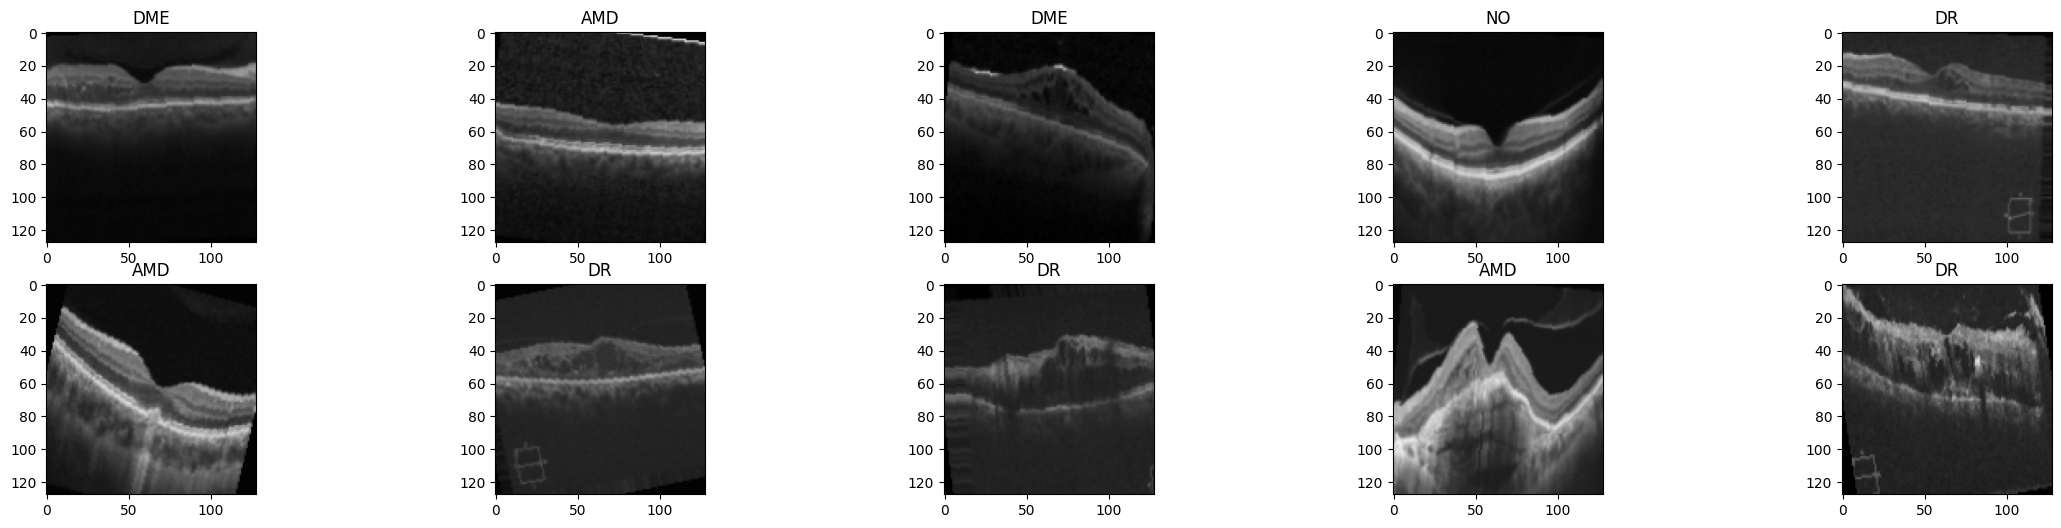

In [ ]:
# sanity check, print some imeages

# grab some sample images - load data in batches of 20, shuffle the images randomly
train_load = torch.utils.data.DataLoader(oct_images, batch_size=20, num_workers=1, shuffle=True)
images, labels = iter(train_load).__next__() # one batch of data from dataloader (first batch)
images = images.numpy()

# Folder names for the classes
classes = ['AMD', 'DME', 'DR', 'NO']

# Plot the images and class labels
figure = plt.figure(figsize=(28, 6)) # figure size (28 x 6 inches)
for i in np.arange(10):
    ax = figure.add_subplot(2, 5, i+1) # 2x5 column grid of subplots
    ax.set_title(classes[labels[i]])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

## Baseline Model - Random Forest


A Random Forest (RF) classifier was implemented using features extracted from a pretrained ResNet-18 model, with its final classification layer removed and used purely as a feature extractor to generate fixed-length embeddings for each image.

In [ ]:

# # Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)


# #  Load pretrained ResNet18 as feature extractor
# resnet = models.resnet18(pretrained=True)
# resnet.fc = nn.Identity()  # remove final classification layer
# resnet = resnet.to(device)
# resnet.eval()

# def extract_features(dataloader):
#     features_list = []
#     labels_list = []
#     with torch.no_grad():
#         for imgs, labels in tqdm(dataloader, desc="Extracting features"):
#             imgs = imgs.to(device)
#             feats = resnet(imgs).cpu().numpy()
#             features_list.append(feats)
#             labels_list.append(labels.numpy())
#     return np.concatenate(features_list), np.concatenate(labels_list)



# print("Extracting train features...")
# X_train, y_train = extract_features(train_loader)
# print("Extracting val features...")
# X_val, y_val = extract_features(val_loader)
# print("Extracting test features...")
# X_test, y_test = extract_features(test_loader)
# print("Feature extraction complete.")

# rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# print("Training Random Forest...")
# rf.fit(X_train, y_train)
# print("Training complete.")

# y_pred = rf.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print(f"\nRandom Forest Accuracy (Test): {acc:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=['AMD','DME','DR','NO']))


# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=['AMD','DME','DR','NO'],
#             yticklabels=['AMD','DME','DR','NO'])
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Random Forest Confusion Matrix")
# plt.show()


## OCT CNN Model


The primary model used for OCT classification is a custom convolutional neural network (CNN), designed to classify OCT images into four categories: AMD, DME, DR, and Normal.

In [ ]:
class OCTCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(OCTCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # Input: 3x128x128 -> 32x128x128
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)  # 32x64x64 -> 64x64x64 after pooling

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # halves spatial dimensions each time

        self.fc1 = nn.Linear(48*16*16, 256)  # 12,288 -> 256
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 128 -> 64

        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 64 -> 32
        x = self.pool(x)  # second pool to reduce 32 -> 16 spatial size

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training & Accuracy

The following are functions for training the model and calculating accuracy.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    model.train()
    accuracy = correct / total
    return accuracy


def train_model(model, train_data, validation_data, batch_size=32, epochs=10, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(f"\nUsing device: {device}")
    print(f"Starting training for {epochs} epochs...\n")

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    torch.manual_seed(50)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = 0, [], [], []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
            iters += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        current_train_acc = get_accuracy(model, train_loader)
        current_val_acc = get_accuracy(model, validation_loader)
        train_acc.append(current_train_acc)
        val_acc.append(current_val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}] "
              f"| Avg Loss: {avg_loss:.4f} "
              f"| Train Acc: {current_train_acc:.4f} "
              f"| Val Acc: {current_val_acc:.4f}")

    print("\nTraining complete!\n")

    # Plot Accuracy
    plt.figure()
    plt.title("Training vs Validation Accuracy")
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.figure()
    plt.title("Training Loss Over Time")
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Overfit


The purpose of overfitting is to ensure verify that the model architecture has enough capacity to learn the training data, otherwise the model architecture may be too simple or underparameterized and may need to be adjusted.

In [ ]:
# import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Subset, DataLoader
# import matplotlib.pyplot as plt

# # small random subset of the training data
# subset_size = 20

# #  train_data is defined from previous steps
# if len(train_data) < subset_size:
#     print(f"Warning: train_data has only {len(train_data)} samples, using full dataset instead.")
#     small_subset_indices = list(range(len(train_data)))
# else:
#     small_subset_indices = random.sample(range(len(train_data)), subset_size)

# small_dataset = Subset(train_data, small_subset_indices)

# # DataLoader for the small subset
# small_loader = DataLoader(small_dataset, batch_size=subset_size, shuffle=True)

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # Initialize model, loss, optimizer

# torch.manual_seed(50)
# myModel = OCTCNN()  # Make sure OCTCNN is defined
# myModel.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(myModel.parameters(), lr=0.01, momentum=0.9)

# # Accuracy helper function
# def get_accuracy(model, data_loader):
#     correct, total = 0, 0
#     model.eval()
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             output = model(images)
#             prediction = output.argmax(dim=1)
#             correct += (prediction == labels).sum().item()
#             total += labels.size(0)
#     model.train()
#     return correct / total if total > 0 else 0

# # Training loop (overfitting small subset)
# iters, losses, train_acc = 0, [], []

# num_epochs = 200
# for epoch in range(num_epochs):
#     myModel.train()
#     epoch_loss = 0
#     num_batches = 0

#     for images, labels in small_loader:
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         outputs = myModel(images)
#         loss = criterion(outputs, labels)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         num_batches += 1
#         iters += 1

#     avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
#     losses.append(avg_loss)

#     current_train_acc = get_accuracy(myModel, small_loader)
#     train_acc.append(current_train_acc)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {current_train_acc:.4f}')

# # Plot training accuracy
# plt.figure()
# plt.title("Training Accuracy (Overfitting Small Subset)")
# plt.plot(train_acc, label='Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot training loss
# plt.figure()
# plt.title("Training Loss (Overfitting Small Subset)")
# plt.plot(losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


## Training OCT Model


Each OCT model is trained below on 3 different sets of hyperparameters, adjusting batch size, learning rate, and the number of epochs. The chosen model for testing is the model that has the highest validation accuracy with stable training.

We are utilizing the GPU

Using device: cuda
Starting training for 15 epochs...

Epoch [1/15] | Avg Loss: 1.3732 | Train Acc: 0.3252 | Val Acc: 0.3411
Epoch [2/15] | Avg Loss: 1.2764 | Train Acc: 0.5438 | Val Acc: 0.5556
Epoch [3/15] | Avg Loss: 1.0980 | Train Acc: 0.6086 | Val Acc: 0.5978
Epoch [4/15] | Avg Loss: 0.9120 | Train Acc: 0.6402 | Val Acc: 0.6467
Epoch [5/15] | Avg Loss: 0.8435 | Train Acc: 0.6626 | Val Acc: 0.6822
Epoch [6/15] | Avg Loss: 0.7830 | Train Acc: 0.6707 | Val Acc: 0.6967
Epoch [7/15] | Avg Loss: 0.7643 | Train Acc: 0.6486 | Val Acc: 0.6278
Epoch [8/15] | Avg Loss: 0.7402 | Train Acc: 0.7045 | Val Acc: 0.7022
Epoch [9/15] | Avg Loss: 0.7259 | Train Acc: 0.7138 | Val Acc: 0.7222
Epoch [10/15] | Avg Loss: 0.7057 | Train Acc: 0.7200 | Val Acc: 0.7167
Epoch [11/15] | Avg Loss: 0.6850 | Train Acc: 0.7117 | Val Acc: 0.7111
Epoch [12/15] | Avg Loss: 0.7031 | Train Acc: 0.7371 | Val Acc: 0.7200
Epoch [13/15] | Avg Loss: 0.6844 | Train Acc: 0.7238 | Val Acc: 0.7100
Epoch

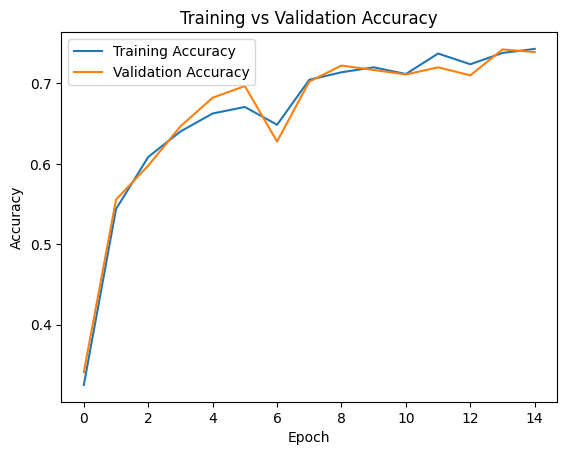

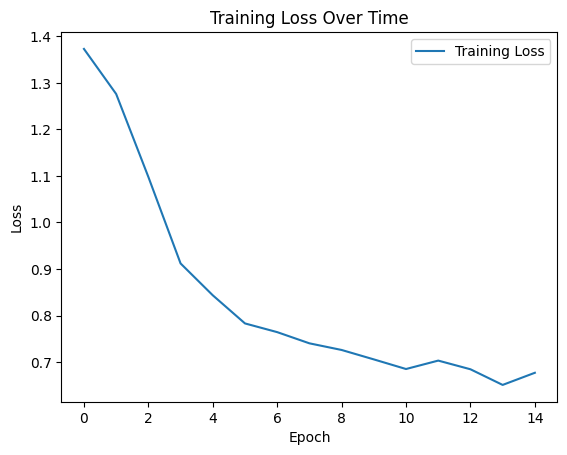

In [ ]:
results = {}

# model A
modelA = OCTCNN()

if torch.cuda.is_available():
    modelA.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

results['A'] = train_model(modelA, train_data, val_data, batch_size=128, lr=0.01, epochs=15)

We are utilizing the GPU

Using device: cuda
Starting training for 20 epochs...

Epoch [1/20] | Avg Loss: 1.3837 | Train Acc: 0.3245 | Val Acc: 0.3400
Epoch [2/20] | Avg Loss: 1.3748 | Train Acc: 0.2962 | Val Acc: 0.2889
Epoch [3/20] | Avg Loss: 1.3611 | Train Acc: 0.3924 | Val Acc: 0.4100
Epoch [4/20] | Avg Loss: 1.3359 | Train Acc: 0.3905 | Val Acc: 0.4078
Epoch [5/20] | Avg Loss: 1.2830 | Train Acc: 0.5045 | Val Acc: 0.5178
Epoch [6/20] | Avg Loss: 1.2183 | Train Acc: 0.5450 | Val Acc: 0.5589
Epoch [7/20] | Avg Loss: 1.1477 | Train Acc: 0.5695 | Val Acc: 0.5778
Epoch [8/20] | Avg Loss: 1.0915 | Train Acc: 0.5798 | Val Acc: 0.5878
Epoch [9/20] | Avg Loss: 1.0262 | Train Acc: 0.6124 | Val Acc: 0.6433
Epoch [10/20] | Avg Loss: 0.9742 | Train Acc: 0.6281 | Val Acc: 0.6311
Epoch [11/20] | Avg Loss: 0.9144 | Train Acc: 0.6219 | Val Acc: 0.6322
Epoch [12/20] | Avg Loss: 0.8711 | Train Acc: 0.6395 | Val Acc: 0.6489
Epoch [13/20] | Avg Loss: 0.8385 | Train Acc: 0.6369 | Val Acc: 0.6478
Epoch

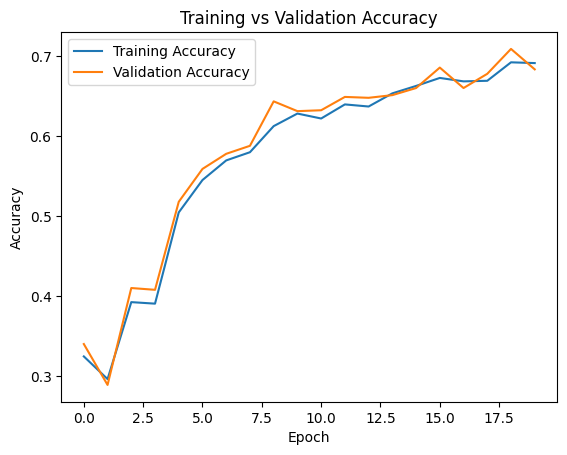

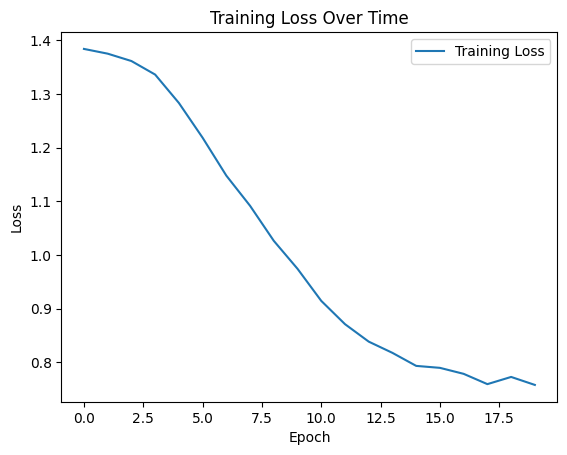

In [ ]:


# model B
modelB = OCTCNN()

if torch.cuda.is_available():
    modelB.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

results['B'] = train_model(modelB, train_data, val_data, batch_size=64, lr=0.001, epochs=20)


We are utilizing the GPU

Using device: cuda
Starting training for 25 epochs...

Epoch [1/25] | Avg Loss: 1.3869 | Train Acc: 0.2402 | Val Acc: 0.2478
Epoch [2/25] | Avg Loss: 1.3849 | Train Acc: 0.2971 | Val Acc: 0.2989
Epoch [3/25] | Avg Loss: 1.3828 | Train Acc: 0.3729 | Val Acc: 0.3600
Epoch [4/25] | Avg Loss: 1.3817 | Train Acc: 0.3183 | Val Acc: 0.3156
Epoch [5/25] | Avg Loss: 1.3797 | Train Acc: 0.2924 | Val Acc: 0.2900
Epoch [6/25] | Avg Loss: 1.3784 | Train Acc: 0.2800 | Val Acc: 0.2722
Epoch [7/25] | Avg Loss: 1.3754 | Train Acc: 0.2736 | Val Acc: 0.2678
Epoch [8/25] | Avg Loss: 1.3738 | Train Acc: 0.2719 | Val Acc: 0.2656
Epoch [9/25] | Avg Loss: 1.3714 | Train Acc: 0.2783 | Val Acc: 0.2756
Epoch [10/25] | Avg Loss: 1.3680 | Train Acc: 0.2736 | Val Acc: 0.2711
Epoch [11/25] | Avg Loss: 1.3641 | Train Acc: 0.2807 | Val Acc: 0.2789
Epoch [12/25] | Avg Loss: 1.3609 | Train Acc: 0.2905 | Val Acc: 0.2967
Epoch [13/25] | Avg Loss: 1.3562 | Train Acc: 0.2952 | Val Acc: 0.2978
Epoch

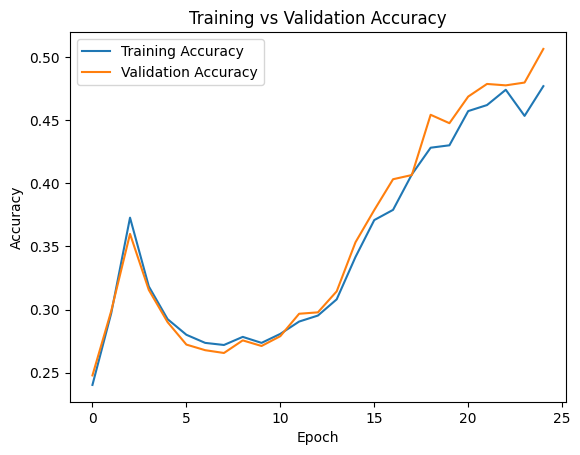

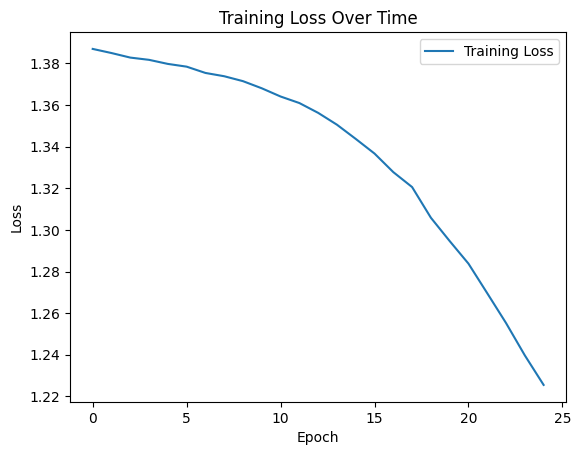

In [ ]:
# model C
modelC = OCTCNN()

if torch.cuda.is_available():
    modelC.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

results['C'] = train_model(modelC, train_data, val_data, batch_size=128, lr=0.0005, epochs=25)


In [ ]:
# model D
modelD = OCTCNN()

if torch.cuda.is_available():
    modelD.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

results['D'] = train_model(modelD, train_data, val_data, batch_size=64, lr=0.001, epochs=30)


We are utilizing the GPU

Using device: cuda
Starting training for 30 epochs...



## Test Best Model (Model D)

In [ ]:
test_load = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
print(get_accuracy(modelD, test_load))

0.7122222222222222


Test accuracy of model D: 71%

## Quantitative Results


 CNN Test Accuracy: 0.7044


Classification Report:
              precision    recall  f1-score   support

         AMD       0.68      0.60      0.64       216
         DME       0.63      0.72      0.67       226
          DR       0.91      0.94      0.92       227
          NO       0.59      0.55      0.57       231

    accuracy                           0.70       900
   macro avg       0.70      0.70      0.70       900
weighted avg       0.70      0.70      0.70       900



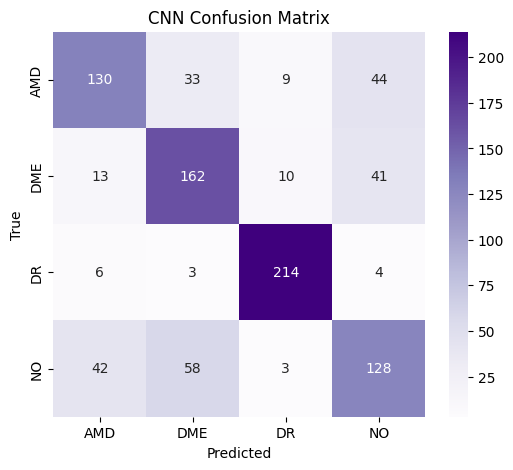

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate model on test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_true = []
y_pred = []

modelD.eval()
with torch.no_grad():
    for imgs, labels in test_load:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = modelD(imgs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['AMD', 'DME', 'DR', 'NO']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['AMD','DME','DR','NO'],
            yticklabels=['AMD','DME','DR','NO'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Qualitative Results


🔍 Showing qualitative examples...



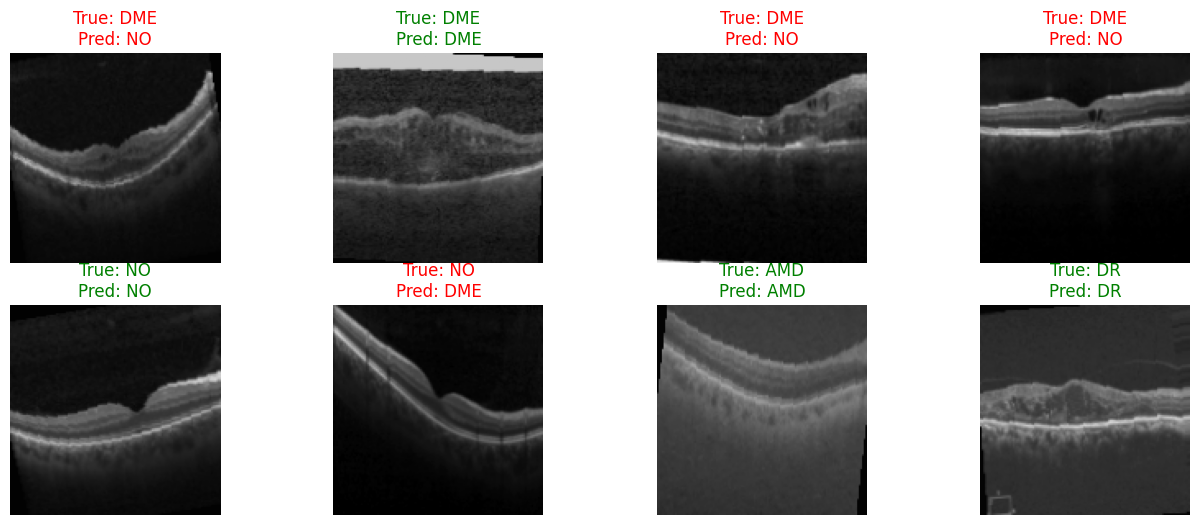

In [ ]:
# Show random images from test set with predicted & true labels
def show_predictions(model, dataset, classes=['AMD','DME','DR','NO'], num_images=8):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)

    plt.figure(figsize=(16, 6))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_img).argmax(dim=1).item()

        img_plot = img.permute(1,2,0).numpy()

        plt.subplot(2, 4, i+1)
        plt.imshow(img_plot)
        color = "green" if pred == label else "red"
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}", color=color)
        plt.axis("off")

    plt.show()

print("qualitative examples")
show_predictions(modelD, test_data)


## Test on New Data

The following images evaluated are from a completely new set of data from a different dataset found on Kaggle: Retinal OCT Images (optical coherence tomography)

In [ ]:
oct_images = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/OCT Project New Test Data', transform=transform_data)
print("Number of Images:", len(oct_images))


# Count how many images belong to each class
class_counts = Counter(oct_images.targets)

# Print
for class_name, class_idx in oct_images.class_to_idx.items():
    print(f"{class_name}: {class_counts[class_idx]} images")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unseen_loader = DataLoader(oct_images, batch_size=batch_size, shuffle=True)

modelD.to(device)
modelD.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in unseen_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = modelD(images)          # forward pass
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# metrics

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['AMD','DME','DR','NO'],
            yticklabels=['AMD','DME','DR','NO'])
plt.title("New Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
